In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [144]:
import hickle

from ase.io import read

import torch
torch.set_default_dtype(torch.float64)
import numpy as np

from mlelec.data.dataset import QMDataset
from mlelec.data.mldataset import MLDataset
from mlelec.models.linear_integrated import LinearModelPeriodic
from mlelec.utils._utils import blocks_to_matrix_opt as blocks_to_matrix

import metatensor.torch as mts
from metatensor.learn import DataLoader

import xitorch
from xitorch.linalg import symeig

from matplotlib import pyplot as plt

In [23]:
orbitals = {
    'sto-3g': {1: [[1,0,0]], 
               5: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]], 
               6: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]], 
               7: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]],
               8: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]]
               }, 
    
    'def2svp': {1: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]],
                6: [[1,0,0],[2,0,0],[3,0,0],[2,1,1], [2,1,-1],[2,1,0], [3,1,1], [3,1,-1],[3,1,0], [3,2,-2], [3,2,-1],[3,2,0], [3,2,1],[3,2,2]],
                8: [[1,0,0],[2,0,0],[3,0,0],[2,1,1], [2,1,-1],[2,1,0], [3,1,1], [3,1,-1],[3,1,0], [3,2,-2], [3,2,-1],[3,2,0], [3,2,1],[3,2,2]]
                },
}

device = 'cpu'

In [148]:
workdir = '../examples/data/water_1000'
frames = read(f'{workdir}/water_1000.xyz',':200')
fock = hickle.load(f'{workdir}/sto-3g/fock.hickle')[:200]
over = hickle.load(f'{workdir}/sto-3g/overlap.hickle')[:200]

In [149]:
qmdata = QMDataset(frames = frames, 
                   kmesh = [1,1,1], 
                   fix_p_orbital_order=True,
                   dimension = 0,
                   fock_realspace=fock,
                   overlap_realspace=list(over),
                   device = device, 
                   orbs = orbitals['sto-3g'], 
                   orbs_name = 'sto-3g'
                )

In [150]:
max_radial  = 8
max_angular = 4
atomic_gaussian_width = 0.3
cutoff = 3.5

hypers_pair = {'cutoff': cutoff,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': atomic_gaussian_width,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.5}}}

hypers_atom = {'cutoff': 4,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': 0.5,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.5}}}


return_rho0ij = False
both_centers = False
LCUT = 3

In [151]:
mldata = MLDataset(qmdata, 
                   item_names = ['fock_realspace', 'overlap_realspace', 'eigenvalues', 'atom_resolved_density'],
                   features = mldata.features,
                   cutoff = hypers_pair['cutoff'],
                   hypers_atom = hypers_atom,
                   hypers_pair = hypers_pair,
                   lcut = 3,
                   orbitals_to_properties = True,
                  )

Features set
Items set


In [152]:
mldata._split_indices(train_frac = 0.8, val_frac = 0.2)
mldata._split_items(mldata.train_frac, mldata.val_frac, mldata.test_frac)

In [176]:
dl = DataLoader(mldata.train_dataset, batch_size = 40, collate_fn = mldata.group_and_join)

In [218]:
def rnd_herm(n, N):
    ''' n: number of matrices 
    N xN : dims of each matrix
    k = num k points 
    '''

    num_samples = (n, N, N)
    
    a = torch.normal(0, 1, num_samples, dtype = torch.float64)
    final_samples = a + a.transpose(1,2).conj()
    
    return final_samples

In [195]:
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)

model = LinearModelPeriodic(twocfeat = mldata.features, 
                            target_blocks = mldata.model_metadata,
                            frames = qmdata.structures, 
                            orbitals = qmdata.basis, 
                            device = device,
                            nhidden = 8, 
                            nlayers = 1,
                            activation = 'SiLU',
                            apply_norm = True
                           )
model = model.double()

In [196]:
optimizer = torch.optim.Adam(model.parameters(), lr = 5e-3, weight_decay = 1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.8, patience = 20)

In [197]:
from mlelec.metrics import Eigval_loss, L2_loss_meanzero, L2_loss
loss_fn = Eigval_loss #L2_loss #_meanzero

In [198]:
n = 100
targets = [rnd_herm(n, f.shape[0]) for f in mldata.items['fock_realspace']] 

In [199]:
eig_var = torch.cat([m.flatten() for m in mldata.items['eigenvalues']]).norm()**2
tar_var = torch.cat([torch.einsum('nij,ji->n', targets[A], mldata.items['density_matrix'][A]).real.flatten() for A in range(len(qmdata))]).norm()**2

In [262]:
def compute_eigval_vec(dataset, batch, Hk, return_rho = False):
    eig = []
    rho = []
    for A, H, S in zip(batch.sample_id, Hk, batch.overlap_realspace):
        # Compute eigenvalues and eigenvectors
        # eigvals, eigvecs = symeig(Ax, M = Mx)
        eigvals, C = symeig(xitorch.LinearOperator.m(H), M = xitorch.LinearOperator.m(S))
        if return_rho:
            frame = dataset.structures[A]
            natm = len(frame)
            ncore = sum(dataset.ncore[s] for s in frame.numbers)
            nelec = sum(frame.numbers) - ncore
            occ = torch.tensor([2.0 if i <= nelec//2 else 0.0 for i in range(C.shape[-1])], dtype = torch.float64, requires_grad = True, device = device)
            rho.append(torch.einsum('n,...in,...jn->ij...', occ, C, C.conj()))
        eig.append(eigvals)
    if return_rho:
        return eig, rho
    else:
        return eig

def compute_ard_vec(dataset, batch, HT, device):
    basis = dataset.basis
    ard_ = []
    eig = []
    
    for A, H, S in zip(batch.sample_id, HT, batch.overlap_realspace):
        frame = dataset.structures[A]
        natm = len(frame)
        ncore = sum(dataset.ncore[s] for s in frame.numbers)
        nelec = sum(frame.numbers) - ncore
        split_idx = [len(basis[s]) for s in frame.numbers]
        needed = True if len(np.unique(split_idx)) > 1 else False
        
        max_dim = np.max(split_idx)
        
        eigvals, C = symeig(xitorch.LinearOperator.m(H), M=xitorch.LinearOperator.m(S), return_eigenvectors = True) # Has shape = (n_k, N, N)
        
        occ = torch.tensor([2.0 if i <= nelec//2 else 0.0 for i in range(C.shape[-1])], dtype = torch.float64, requires_grad = True, device = device)
        P = torch.einsum('n,...in,...jn->ij...', occ, C, C.conj())

        slices = torch.split(P, split_idx, dim=0)
        blocks = [torch.split(slice_, split_idx, dim=1) for slice_ in slices]
        blocks_flat = [block for sublist in blocks for block in sublist]
        
        if needed:
            squared_blocks = []
            for block in blocks_flat:
                pad_size = (0, max_dim - block.size(1), 0, max_dim - block.size(0))
                squared_block = torch.nn.functional.pad(block, pad_size, "constant", 0)
                squared_blocks.append(squared_block)
            blocks_flat = squared_blocks


        ard_.append(torch.stack(blocks_flat).norm(dim=(1,2)))
        eig.append(eigvals)
    
    return eig, ard_

In [265]:
alpha = 1
nepoch = 1000
losses = []
for epoch in range(nepoch):

    epoch_loss = 0
    epoch_loss_e = 0
    epoch_loss_t = 0

    # Train against real space targets
    for ib, batch in enumerate(dl):
        
        model.train(True)
        optimizer.zero_grad()
        
        pred = model.forward(batch.features, mldata.model_metadata)
        HT = blocks_to_matrix(pred, qmdata, detach = False, structure_ids=batch.sample_id)
        HT = [h[0,0,0] for h in HT]
        
        pred_eigvals = compute_eigval_vec(qmdata, batch, HT, return_rho=False)
        # pred_eigvals, pred_rho = compute_eigval_vec(qmdata, batch, HT, return_rho=True)
        # trace_loss = sum((torch.einsum('nij...,ji...->n...', targets[A], pred_rho[Ab] - batch.density_matrix[Ab]).real**2).sum() for Ab, A in enumerate(batch.sample_id))/tar_var
        loss_e = loss_fn(pred_eigvals, batch.eigenvalues)/eig_var
        loss = alpha*loss_e #+ trace_loss  #+ loss_fn(pred_ard, batch.atom_resolved_density)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_loss_e += loss_e.item()
        epoch_loss_t += trace_loss.item()
    
    scheduler.step(epoch_loss)
    losses.append(epoch_loss)
    
    if epoch >= 0: #% 10 == 0:
        print(f"Epoch {epoch:>7d}, train loss {np.sqrt(epoch_loss):>15.10f} {np.sqrt(epoch_loss_e):>15.10f} {np.sqrt(epoch_loss_t):>15.10f}")

Epoch       0, train loss    0.0100021900    0.0100021900    0.0150402948
Epoch       1, train loss    0.0100022690    0.0100022690    0.0150402948
Epoch       2, train loss    0.0100023481    0.0100023481    0.0150402948
Epoch       3, train loss    0.0100024271    0.0100024271    0.0150402948
Epoch       4, train loss    0.0100025061    0.0100025061    0.0150402948
Epoch       5, train loss    0.0100025851    0.0100025851    0.0150402948
Epoch       6, train loss    0.0100026640    0.0100026640    0.0150402948
Epoch       7, train loss    0.0100027429    0.0100027429    0.0150402948
Epoch       8, train loss    0.0100028217    0.0100028217    0.0150402948
Epoch       9, train loss    0.0100029006    0.0100029006    0.0150402948
Epoch      10, train loss    0.0100029794    0.0100029794    0.0150402948
Epoch      11, train loss    0.0100030582    0.0100030582    0.0150402948
Epoch      12, train loss    0.0100031369    0.0100031369    0.0150402948
Epoch      13, train loss    0.0100032

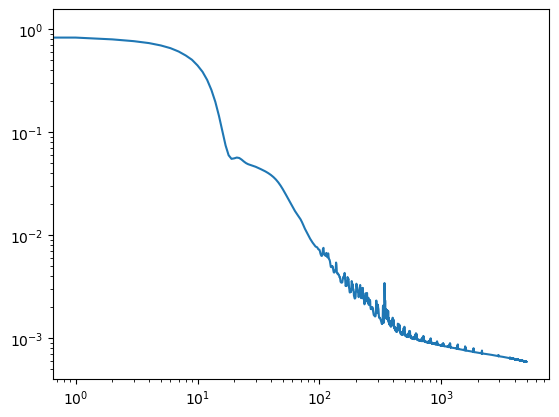

In [203]:
plt.loglog(losses)

In [207]:
val_dl = DataLoader(mldata.val_dataset, batch_size = len(mldata.val_dataset), collate_fn=mldata.group_and_join)

In [250]:
batch = next(iter(val_dl))
pred = model(batch.features, mldata.model_metadata)

In [251]:
HT = blocks_to_matrix(pred, qmdata, detach = True, structure_ids=batch.sample_id)
HT = [h[0,0,0] for h in HT]

# pred_eigvals = compute_eigval_vec(qmdata, batch, HT, return_rho=False)
pred_eigvals, pred_rho = compute_eigval_vec(qmdata, batch, HT, return_rho=True)

In [253]:
n = 100
targets = [rnd_herm(n, f.shape[0]) for f in mldata.items['fock_realspace']] 

In [254]:
pred_trace = torch.cat([torch.einsum('nij...,ji...->n...', targets[A], pred_rho[Ab].detach()) for Ab, A in enumerate(batch.sample_id)])
true_trace = torch.cat([torch.einsum('nij...,ji...->n...', targets[A], batch.density_matrix[Ab].detach().real) for Ab, A in enumerate(batch.sample_id)])

Text(0.5, 1.0, 'Random hermitian targets')

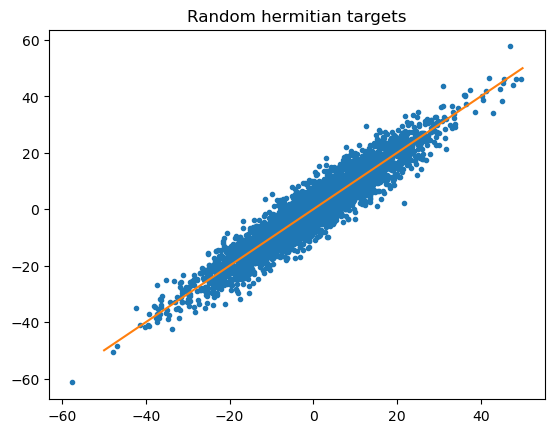

In [269]:
plt.plot(true_trace, pred_trace, '.')
plt.plot([-50, 50], [-50, 50])
plt.title('Random hermitian targets')

Text(0.5, 1.0, 'Eigenvalues')

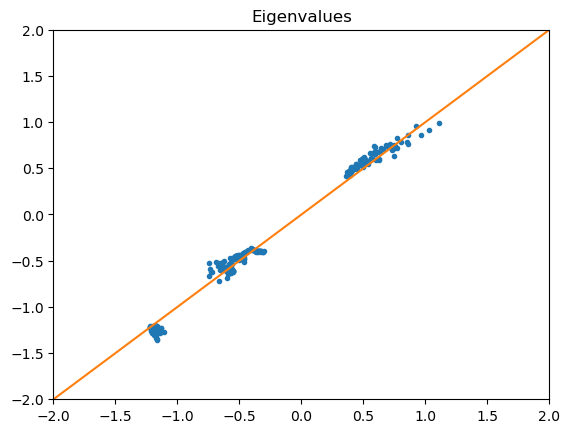

In [270]:
plt.plot(torch.cat(pred_eigvals).detach(), batch.eigenvalues.flatten(), '.')
plt.plot([-21, 2], [-21, 2])
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.title('Eigenvalues')


In [263]:
_, pred_ard = compute_ard_vec(qmdata, batch, HT, device)

Text(0.5, 1.0, 'Mayer bond charges')

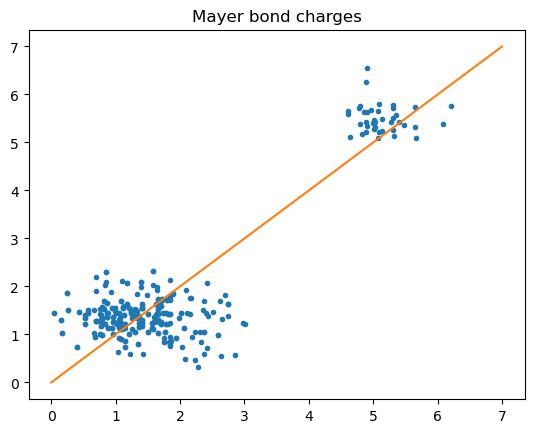

In [272]:
plt.plot(batch.atom_resolved_density.flatten(), torch.stack(pred_ard).detach().flatten(), '.')
plt.plot([0,7], [0,7])
plt.title('Mayer bond charges')